## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from time import time, sleep
from random import choice
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Prepare for viewing long text in CSVs

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the two data files

In [4]:
subtweets_data = json.load(open("../data/other_data/subtweets.json"))

In [5]:
non_subtweets_data = json.load(open("../data/other_data/non_subtweets.json"))

#### Find the length of the smaller dataset

In [6]:
largest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Check the lengths and see examples
#### Cut down both datasets to be the same size

In [7]:
subtweets_data = [t["tweet_data"]["full_text"] for t in subtweets_data][:largest_length]

In [8]:
print("Subtweets dataset length: {}".format(len(subtweets_data)))

Subtweets dataset length: 4257


In [9]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
My WhatsApp contacts upload normal stats and are chilled on WhatsApp but when it comes to twitter they are the most vile crazy nonsensical humans on earth the change up is so real 👀


In [10]:
non_subtweets_data = [t["tweet_data"]["full_text"] for t in non_subtweets_data][:largest_length]

In [11]:
print("Non-subtweets dataset length: {}".format(len(non_subtweets_data)))

Non-subtweets dataset length: 4257


In [12]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
See, this is what seperates us Berners from you Hillary supporters. 

We would NEVER wish anything bad or catastrophic on anybody simply because of who they suppirt politically. 

We would GLADLY fight for YOU &amp; EVERYBODY else to have great health care. 

So who's the bad guy? https://t.co/yK9j5hlG0h


#### Prepare data for training

In [13]:
subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                   "positive") for tweet in subtweets_data]

In [14]:
non_subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                       "negative") for tweet in non_subtweets_data]

#### Combine them

In [15]:
training_data = subtweets_data + non_subtweets_data

#### Create training and test sets from the single training set I made before

In [16]:
text_train, text_test, class_train, class_test = train_test_split([row[0] for row in training_data], 
                                                                  [row[1] for row in training_data])

#### Use NLTK's tokenizer instead of Scikit's

In [17]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [18]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        others = ["You", "You're", "Youre", "Your", "Yours", "U", "Ur", "Urs",
                  "She", "She's", "Shes", "Her", "Hers", 
                  "He", "He's", "Hes", "Him", "His", 
                  "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        others_lower = set([other.lower() for other in others])
        
        selfs = ["I", "I'm", "Im", "We", "We're", "Our", "Ours", "My", "Mine", "Us"]
        selfs_lower = set([self.lower() for self in selfs])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_others = len(others_lower.intersection(tokenized_text))
            num_selfs = len(selfs_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            
            
            weighted_dict = {"num_subtweet": num_subtweet,
                             "num_at_symbols": num_at_symbols, 
                             "num_urls": num_urls,
                             "num_others": num_others,
                             "num_selfs": num_selfs}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [19]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [20]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [21]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.72      0.61      0.66      1063
   positive       0.66      0.77      0.71      1066

avg / total       0.69      0.69      0.69      2129



#### Define function for visualizing confusion matrices

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

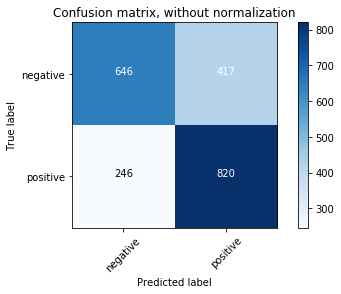

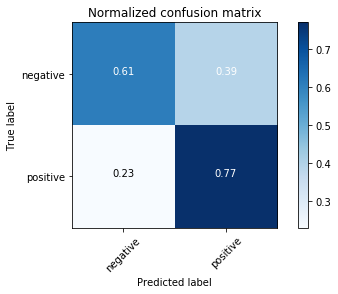

In [23]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [24]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [25]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [26]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [27]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [28]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1,None,0.099963,0.900037,Isn't it funny how some people don't know their place?
2,None,0.125532,0.874468,How come you people act like this?
0,None,0.130037,0.869963,Some people don't know their place.
3,None,0.176549,0.823451,You're such a nerd.
4,None,0.340405,0.659595,"I love Noah, he's so cool."


#### Test on actual tweets

In [29]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [30]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [31]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [32]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [33]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### Use randomly selected 5K rows from dataset

In [34]:
naji_df = naji_df.sample(n=5000).reset_index(drop=True)

#### Print and time the tests

In [35]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 960 ms, sys: 19.9 ms, total: 979 ms
Wall time: 988 ms


In [36]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

#### Plot the results

In [37]:
naji_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [38]:
naji_df_for_plotting = naji_df.drop(naji_df_columns, axis=1).head(10)

In [39]:
naji_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
215,0,0.040247,0.959753,"""spiritual people"" who say they hope this is their *last life* make me think, ""wow, you're REALLY not having a GOOD TIME, are you?"" sad"
1916,0,0.047170,0.952830,u know u need to do laundry when you have to choose clothes to wear based on whether or not you can go commando in them
1459,1,0.074172,0.925828,facebook suggests your friends friend believing you would know your friends friend
4134,1,0.082046,0.917954,"Teacher: ""Shut your books!"" Me *whisper*: ""Let's leave it open and look if he'll notice!"" Her: ""Oh, yeah, you're so rebellious!"" lol"
190,1,0.082554,0.917446,"abcMarc..since you don't follow here it is when somebody let's their dog poop and not clean up don't yell at them, just whip out a bag &"
3051,1,0.086580,0.913420,so dont let them non-true things get 2 u n at everything n stay true 2 ur self
2192,0,0.087335,0.912665,"i NEED a trim, my bangs are so grown out they dont do theyre thang no mo"
1652,0,0.096867,0.903133,saying that with 100 pills thats what ppl use to make meth i said well i want them for my sinus and he kept laughing
114,0,0.100609,0.899391,I guess I just won't talk to you because it seems like that what you want. Just don't leave without saying goodbye. Please.
4114,0,0.112697,0.887303,What is up to all my st.louis friends 2day?they r busy n dont have time to hang out with me im just glad that edward is keeping me c ...


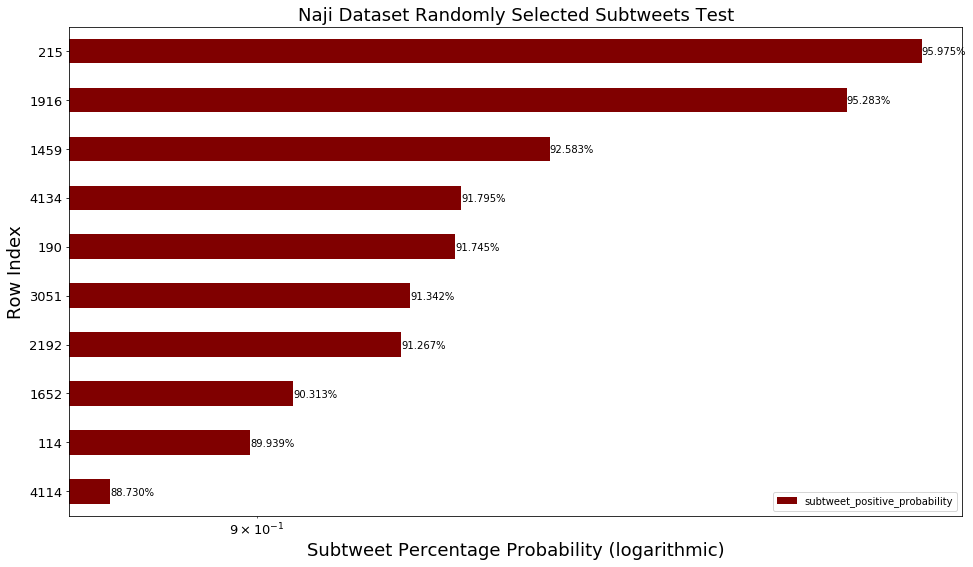

In [40]:
ax = naji_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Naji Dataset Randomly Selected Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Tests on friends' tweets

#### Aaron

In [41]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [42]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 625 ms, sys: 8.51 ms, total: 633 ms
Wall time: 634 ms


In [43]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [44]:
aaron_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [45]:
aaron_df_for_plotting = aaron_df.drop(aaron_df_columns, axis=1).head(10)

In [46]:
aaron_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2893,None,0.042971,0.957029,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
1600,None,0.044008,0.955992,"shoutout to all the people tweeting #BeforeTheInternetExisted saying ""we actually talked to people face to face"" bc u know they're guilty"
385,None,0.060121,0.939879,My dog literally changed positions on my bed just so she could watch me eat at my desk but pretends she asleep when I look at her like I can't tell when she huffs and puffs because she's not getting any
821,None,0.060268,0.939732,tfw you're proud of something and want to share it with others but you realize that nobody actually cares
1994,None,0.063412,0.936588,i can't believe noah just trolls twitter waiting for you to tweet so he can respond without you tagging him
2438,None,0.067636,0.932364,the ultimate subtweet is the one where nobody is certain who you're talking about but there's always the possibility it's them
3284,None,0.067850,0.932150,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯
2745,None,0.069417,0.930583,tfw the Internet in your classroom doesn't work so you have to pay attention instead of browsing buzzfeed
2906,None,0.071156,0.928844,"tfw you're walking home and bros stop you and ask if you want to ""smoke some bud"" with them"
2445,None,0.072073,0.927927,If you don't have tweet notifications turned on for me are we really friends


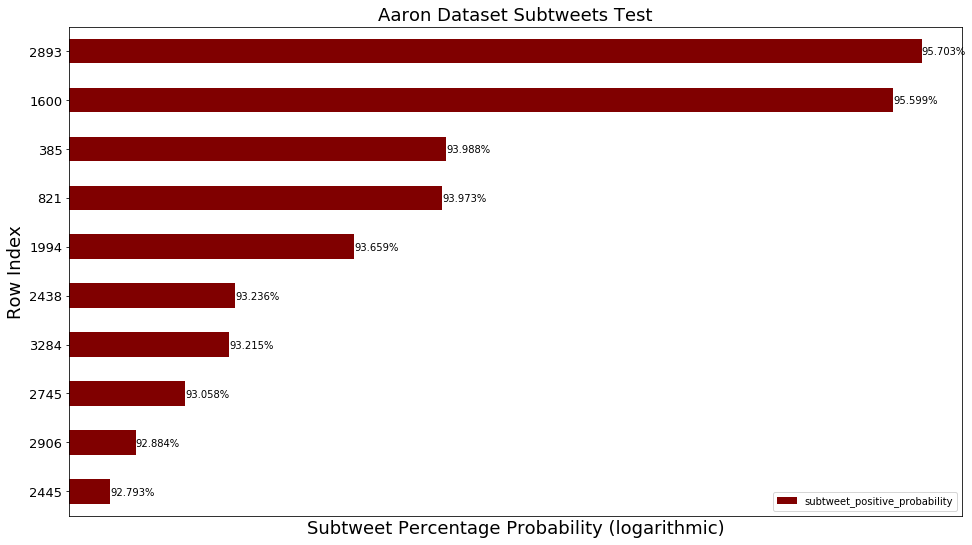

In [47]:
ax = aaron_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Aaron Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Julia

In [48]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [49]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.4 s, sys: 15.1 ms, total: 1.41 s
Wall time: 1.42 s


In [50]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [51]:
julia_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [52]:
julia_df_for_plotting = julia_df.drop(julia_df_columns, axis=1).head(10)

In [53]:
julia_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2926,None,0.028653,0.971347,"if ur white and u didn't grow up saying ""y'all"" but you do now bc #trendy, consider NOT doing that"
663,None,0.038604,0.961396,even if you are committed to cheating how can you possibly think that p/c are on the same level as v/m when you're watching papadakis shakily clamber onto cizeron for a lift in their short dance after you've just seen tessa hook her legs around scott's head and spin in THEIR ...
4629,None,0.040528,0.959472,how do you tell ur coach who probably hates ur forgetful ass at this point that you can't go to practice bc u stayed up all night lmk
2478,None,0.041850,0.958150,when u hear about someone with a 4.0 secondhand and and immediately despise them for no other reason than their 4.0
773,None,0.042696,0.957304,"""I do feel grateful for the fact that we have one another, because I think people search their whole lives for someone that special"" -tessa\n\nwho even says this about somebody that they don't want to marry/be with forever? v/m soundbytes will be the death of me #virtuemoir"
6086,None,0.043304,0.956696,tfw ur anxiety kills ur appetite but you can't do anything done bc ur still hungry so u just get more anxiety #gr8
4395,None,0.047032,0.952968,"if you continually cross post content on various social media to get validation that you're funny, you, regrettably, are probably not funny"
4071,None,0.047851,0.952149,"if u rly need motivation, call it an incentive of honesty: people don't think ur going to cheat them all the fucking time. amazing!"
6569,None,0.048105,0.951895,tfw really wanting to get out of class to work on ur essay but once ur back in ur dorm u want to do ANYTHING BUT WRITE THIS ESSAY
1138,None,0.049173,0.950827,"""what a COINcidence that you're here,"" drawls Bitcoin lustily. your palms sweat as you imagine what it would be like to own this creature, to do with him what you will. you drag your cursor over his coinhood, and he gasps. \n""transaction complete,"" you whisper into his ear la..."


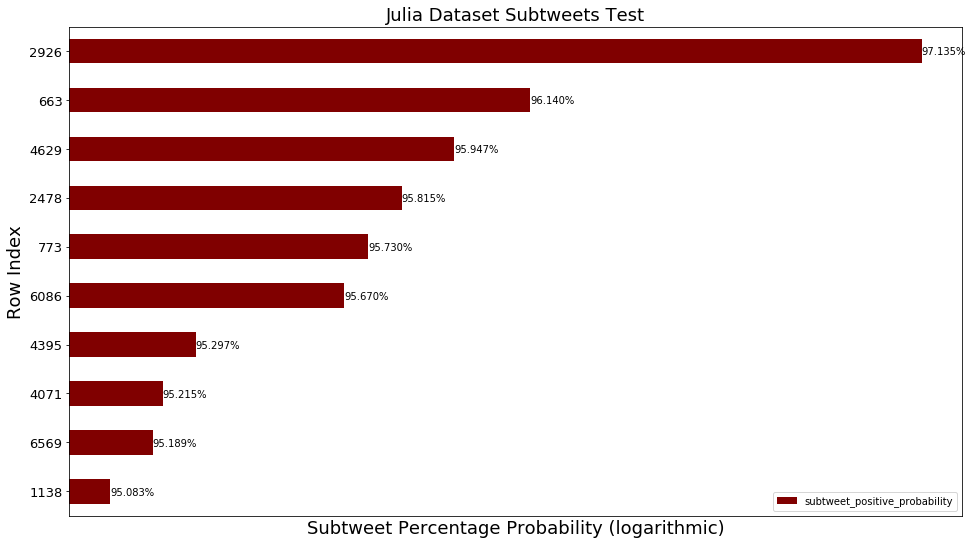

In [54]:
ax = julia_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Julia Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Zoe

In [55]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [56]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 231 ms, sys: 4.08 ms, total: 235 ms
Wall time: 250 ms


In [57]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [58]:
zoe_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [59]:
zoe_df_for_plotting = zoe_df.drop(zoe_df_columns, axis=1).head(10)

In [60]:
zoe_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
583,None,0.042551,0.957449,"and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when, in reality, it's probably people forgetting because you, and your particular brand of anxiety, bounce haphazardly from one mood 2 the ..."
848,None,0.049579,0.950421,that one buzzfeed employee who thinks they're really funny but they aren't
216,None,0.056068,0.943932,did you say no and you're mad i would dare suggest such a change or are you mad someone said no
1115,None,0.056531,0.943469,if u don't watch all ur snap friends stories ur probably 2 self-involved
303,None,0.057327,0.942673,they say pets can sense when ur Not Okay™ and I think it's true bc pinwheel refuses to fall asleep anywhere but on my lap/chest
788,None,0.058161,0.941839,u ever read a tweet and ur like damn did u write that just to upset me??? Well it only worked for three seconds
277,None,0.062675,0.937325,ok so people from my old school keep lamenting the death of someone to whom they claim to be close but also like continually misgender them in their lamentations?? I Don't Like This
456,None,0.068010,0.931990,when ur heart rate is fast before bed and u can't tell if it's the anxiety heart rate or the insomnia heart rate BUT you realize you're not anxious so it's probably the insomnia \n\nwelcome back old friend you have not been missed
208,None,0.075101,0.924899,u posted this tweet moments after i got 2 insta notifications for live videos and i'm choosing to assume that you got the same notifications
906,None,0.076053,0.923947,it drives me fucking INSANE when the fucking animal is in the fucking fruit orchard and WANTS YOU TO GIVE IT FUCKIMGM FRUIT GET IT YOUR SELF PUNCHY SMH


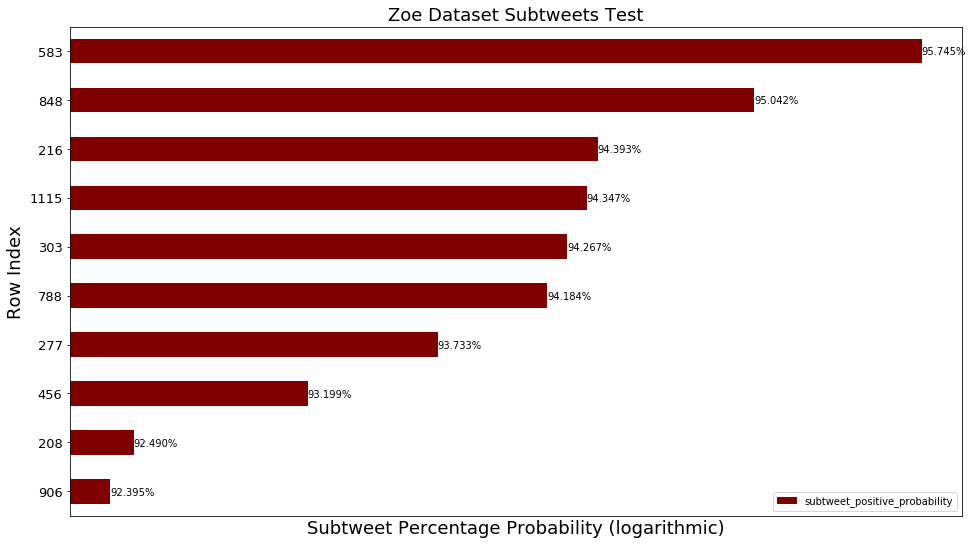

In [61]:
ax = zoe_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Zoe Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Noah

In [62]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [63]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 771 ms, sys: 9.01 ms, total: 780 ms
Wall time: 781 ms


In [64]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [65]:
noah_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [66]:
noah_df_for_plotting = noah_df.drop(noah_df_columns, axis=1).head(10)

In [67]:
noah_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
4166,None,0.031084,0.968916,TFW your old boss walks into DTR and you feel like you're supposed to look like you're working even though you don't work for her
3525,None,0.037248,0.962752,some people want their kids to take care of them when they are elderly but I plan to enslave sentient AI to do that for me until the end.
2891,None,0.037751,0.962249,When you're telling me to die or making me feel inferior I don't like you but you're normally very kind so I'm content with that
4192,None,0.040777,0.959223,You ever wonder how your siblings are when you're not with them? haha me neither
3236,None,0.040875,0.959125,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
3766,None,0.049675,0.950325,TFW you forget you're logged in to your twitter bot and you accidentally Tweet from it
877,None,0.050907,0.949093,I guess I think it’s foolish to rely on any website for being your source of personal fulfillment and especially as your only source for political change. The companies which own your speech aren’t going to let you dismantle them. And their goal isn’t ever going to be to help...
992,None,0.056568,0.943432,wow the bots really likes this tweet\nBUT YOU DONT KNOW\nWHAT THEY WENT THROUGH\nFOR HER TO OPEN UP\nAND *NOT* BE A SOCIOPATHIC MURDERER\nand I think it was only 2-3 times
3249,None,0.057823,0.942177,IF U CALL URSELF A WEEB BUT DONT HAVE ANIME PROF PICS ON ALL SOCIAL MEDIA\n DELETE UR ACCOUNTS
4115,None,0.062193,0.937807,Tbh if you're a confident person I both envy you and can't wait for you to realize that all your efforts will ultimately fade into the void


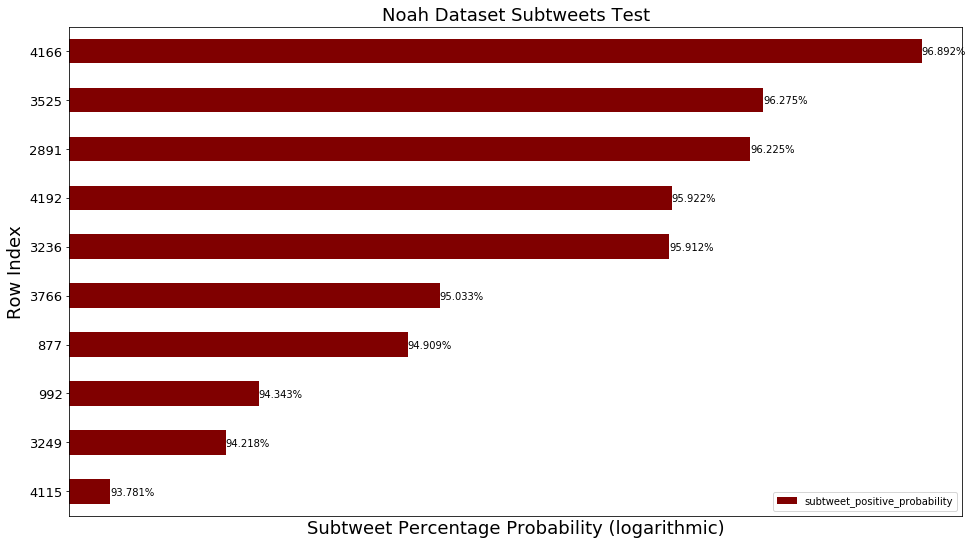

In [68]:
ax = noah_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Noah Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Test it in realtime
#### Define some useful variables for later

In [69]:
THRESHOLD = 0.95 # 95% positives and higher, only
DURATION = 60 # 1 minute

#### Load Twitter API credentials

In [70]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Use the API credentials to connect to the API

In [71]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=1, timeout=120, # 2 minutes
                 compression=True, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Prepare the final dataframe

In [72]:
subtweets_live_list = []
non_subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [73]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        choices = ["retweet", "like", "retweet and like", "reply"]
        
        id_str = status.id_str
        screen_name = status.user.screen_name
        created_at = status.created_at
        retweeted = status.retweeted
        in_reply_to = status.in_reply_to_status_id
        
        text = status.text.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<")
        
        # negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability}
        
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD, 
                not retweeted,
                "RT @" not in text, 
                not in_reply_to]):
            
            decision = choice(choices)
            if decision == "retweet":
                api.update_status(("Is this a subtweet? {:.3%} \n" + 
                                   "https://twitter.com/{}/status/{}").format(positive_probability, 
                                                                              screen_name, 
                                                                              id_str))
            
            if decision == "like":
                api.create_favorite(id_str)
            
            if decision == "retweet and like":
                api.update_status(("Is this a subtweet? {:.3%} \n" + 
                                   "https://twitter.com/{}/status/{}").format(positive_probability, 
                                                                              screen_name, 
                                                                              id_str))
                api.create_favorite(id_str)
            
            if decision == "reply":
                api.update_status("@{} Is this a subtweet? {:.3%}".format(screen_name, positive_probability), id_str)
            
            subtweets_live_list.append(row)
            subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                         ascending=False)
            
            subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv")
            
            print(("Subtweet from @{0} (Probability of {1:.3%}):\n" + 
                   "Time: {2}\n" + 
                   "Tweet: {3}\n" +
                   "Total tweets acquired: {4}\n").format(print_list[0], 
                                                          print_list[1], 
                                                          print_list[2],
                                                          print_list[3],
                                                          (len(subtweets_live_list) 
                                                           + len(non_subtweets_live_list))))
            
            return row
        else:
            non_subtweets_live_list.append(row)
            non_subtweets_df = pd.DataFrame(non_subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                                 ascending=False)
            non_subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/non_subtweets_live_data.csv")
            
            return row

#### Get a list of the IDs of all my mutuals and my mutuals' followers

In [74]:
def get_mutuals():
    my_followers = [str(user_id) for ids_list in 
                    tweepy.Cursor(api.followers_ids, 
                                  screen_name="NoahSegalGould").pages() 
                    for user_id in ids_list]
    my_followeds = [str(user_id) for ids_list in 
                   tweepy.Cursor(api.friends_ids, 
                                 screen_name="NoahSegalGould").pages() 
                   for user_id in ids_list]
    
    my_mutuals = list(set(my_followers) & set(my_followeds))
    
    bots = ["890031065057853440", "895685688582180864", 
            "894658603977777152", "970553455709446144", 
            "786489395519983617", "975981192817373184"]
    
    my_mutuals = [m for m in my_mutuals if m not in bots]
    
    with open("../data/other_data/NoahSegalGould_Mutuals_ids.json", "w") as outfile:
        json.dump(my_mutuals, outfile)
    
    return my_mutuals

In [75]:
def get_mutuals_and_mutuals_mutuals_ids(mutuals_threshold=250):
    my_mutuals = get_mutuals()
    my_mutuals_mutuals = my_mutuals[:]

    for i, mutual in enumerate(my_mutuals):
        start_time = time()
        user = api.get_user(user_id=mutual)
        name = user.screen_name
        is_protected = user.protected
        if not is_protected:
            mutuals_followers = []
            followers_cursor = tweepy.Cursor(api.followers_ids, user_id=mutual).items()
            while True:
                try:
                    mutuals_follower = followers_cursor.next()
                    mutuals_followers.append(str(mutuals_follower))
                except tweepy.TweepError:
                    sleep(30) # 30 seconds
                    continue
                except StopIteration:
                    break
            mutuals_followeds = []
            followeds_cursor = tweepy.Cursor(api.friends_ids, user_id=mutual).items()
            while True:
                try:
                    mutuals_followed = followeds_cursor.next()
                    mutuals_followeds.append(str(mutuals_followed))
                except tweepy.TweepError:
                    sleep(30) # 30 seconds
                    continue
                except StopIteration:
                    break
            mutuals_mutuals = list(set(mutuals_followers) & set(mutuals_followeds))
            print("{} mutuals for mutual {}: {}".format(len(mutuals_mutuals), i+1, name))
            if len(mutuals_mutuals) <= mutuals_threshold: # Ignore my mutuals if they have a lot of mutuals
                my_mutuals_mutuals.extend(mutuals_mutuals)
            else:
                print("\tSkipping: {}".format(name))
        else:
            continue
        end_time = time()
        with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json", "w") as outfile:
            json.dump(my_mutuals_mutuals, outfile)
        print("{0:.2f} seconds for getting the mutuals' IDs of mutual {1}: {2}\n".format((end_time - start_time), 
                                                                                         i+1, name))
    my_mutuals_mutuals = [str(mu) for mu in sorted([int(m) for m in list(set(my_mutuals_mutuals))])]
    with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json", "w") as outfile:
        json.dump(my_mutuals_mutuals, outfile, indent=4)
    return my_mutuals_mutuals

In [76]:
# %%time
# my_mutuals_mutuals = get_mutuals_and_mutuals_mutuals_ids()

In [77]:
# %%time
# my_mutuals = get_mutuals()

In [78]:
# my_mutuals_mutuals = json.load(open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json"))

In [79]:
# print("Total number of my mutuals: {}".format(len(my_mutuals)))

In [80]:
# print("Total number of my mutuals and my mutuals' mutuals: {}".format(len(my_mutuals_mutuals)))

#### Instantiate the listener

In [81]:
# stream_listener = StreamListener()
# stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [82]:
# %%time
# stream.filter(locations=[-73.920176, 42.009637, -73.899739, 42.033421], stall_warnings=True, languages=["en"], async=True)
# stream.filter(follow=my_mutuals_mutuals, stall_warnings=True, languages=["en"], async=True)
# print("Streaming has started.")
# sleep(DURATION)
# stream.disconnect()

#### Plot the results

In [83]:
# subtweets_df = pd.read_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv", index_col=0)

In [84]:
# subtweets_df_columns = ["screen_name", "time", "tweet"]

In [85]:
# subtweets_df_for_plotting = subtweets_df.drop(subtweets_df_columns, axis=1).head(10)

In [86]:
# subtweets_df.head(10)

In [87]:
# ax = subtweets_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
# ax.set_alpha(0.8)
# ax.set_title("Live Downloaded Subtweets Test", fontsize=18)
# ax.set_ylabel("Row Index", fontsize=18);
# ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
# for i in ax.patches:
#     ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
# ax.invert_yaxis()